# บทที่ 5. โครงข่ายประสาทเทียมวกกลับ

ปัญหาการเรียนรู้เชิงลึกที่เราได้ศึกษาจนถึงบทนี้จะเห็นว่าข้อมูลแต่ละตัวอย่างไม่มีความสัมพันธ์กัน 
เช่นการจำแนกภาพสุนัขและแมวที่โมเดลรับอินพุตแต่ละภาพเป็นเอกเทศ 
ในบทนี้จะพิจารณากรณีข้อมูลมีลักษณะเป็นลำดับ (sequence) เช่นชุดของภาพแมวที่ถ่ายจากวีดีโอขณะกำลังวิ่ง 
และต้องการให้โมเดลเรียนรู้การเคลื่อนไหวของวัตถุในภาพ หากอินพุตเป็นภาพแมวเพียงภาพเดียว 
เราอาจไม่ทราบได้ว่าแมวจะเคลื่อนไหวอย่างไรต่อไป แต่ถ้าเป็นลำดับของภาพชุดหนึ่งของแมววิ่งจากซ้ายไปขวา 
โมเดลสามารถจำแนกได้ว่าเป็นกิจกรรมการวิ่ง หรือพยากรณ์ตำแหน่งต่อไปของแมวได้

ปัญหาที่เกี่ยวข้องกับข้อมูลลำดับเป็นโจทย์สำคัญด้านการเรียนรู้เชิงลึกที่ครอบคลุมการใช้งานหลายรูปแบบ 
เช่นการประมวลผลภาษาธรรมชาติ (natural language processing นิยมเรียกโดยย่อว่า NLP) การแปลภาษาโดยเครื่อง
การรู้จำเสียงพูด (speech recognition) การกำเนิดดนตรี การจำแนกอารมณ์ (sentiment classification) 
การวิเคราะห์ลำดับ DNA การรู้จำกิจกรรมจากลำดับภาพวีดีโอ เป็นต้น

โดยลักษณะของโจทย์ปัญหาที่แตกต่างนี้ทำให้สถาปัตยกรรมโครงข่ายประสาทเทียมแบบ DNN หรือ CNN มีข้อด้อยสองประการคือ 

<ol>
<li />ไม่สามารถเรียนรู้และใช้ประโยชน์จากความสัมพันธ์ของข้อมูลลำดับ
<li />อินพุตมีลักษณะที่มีขนาดไม่คงที่ เช่นจำนวนอักขระในแต่ละคำ
</ol>

ในบทนี้เราจะนำเสนอโมเดลที่เหมาะสมสำหรับงานในรูปแบบนี้

## 5.1 สัญกรณ์สำหรับข้อมูลลำดับ

ก่อนเริ่มต้นการศึกษาในบทนี้จะนิยามสัญกรณ์เพิ่มเติมสำหรับข้อมูลลำดับ โดยยกตัวอย่างคำภาษาอังกฤษที่ประกอบเป็นประโยค 
ซึ่งหลักการสามารถประยุกต์กับภาษาโดยทั่วไป กรณีที่เป็นภาษาไทยจะมีความซับซ้อนเพิ่มขึ้นจากการตัดคำในประโยค 
ซึ่งมิใช่ส่วนที่ต้องการเน้นในด้านการเรียนรู้เชิงลึก

สมมุติว่าต้องการสร้างโมเดลลำดับเพื่อรับประโยคอินพุตดังนี้

X : Yngwie Malmsteen and Steve Vai performed together in Boston.
    
และต้องการให้โมเดลจำแนกว่าคำใดบ้างที่เป็นชื่อของคน ดังนั้นต้องการเอาต์พุต y มีค่าเป็น 1 หากคำนั้นเป็นส่วนของชื่อคน 
(ชื่อหรือนามสกุล) หากไม่ใช่ให้มีค่าเป็น 0 ดังนั้นจากประโยคอินพุตนี้จะได้เอาต์พุตเท่ากับ

$$
Y =  [1, 1, 0, 1, 1, 0, 0, 0, 0] 
$$    

ต้องการแทนแต่ละคำในประโยคของอินพุตด้วยสัญกรณ์โดย $x^{<t>}$ ซึ่ง $t$ คือตัวชี้ตำแหน่งของคำในประโยค 
ดังนั้นอินพุตจากประโยคด้านบนแทนได้เป็นดังนี้

$$
X = [x^{<1>}, x^{<2>}, \ldots, x^{<t>}, \ldots, x^{<9>}]
$$

และเอาต์พุต

$$
Y = [y^{<1>}, y^{<2>}, \ldots, y^{<t>}, \ldots, y^{<9>}]
$$

ให้ $T_x, T_y$ แทนจำนวนสมาชิกของอินพุตและเอาต์พุตตามลำดับ จากตัวอย่างนี้มีจำนวนเท่ากันคือ $9$ 
แต่โดยทั่วไปแล้วไม่จำเป็นต้องเท่ากัน 

ทบทวนจากสัญกรณ์เดิมเราใช้ $x^{(i)}, y^{(i)}$ แทนอินพุตและเอาต์พุตตัวอย่างที่ $i$ ดังนั้น 
$x^{(i)<t>}, y^{(i)<t>}$ แทนอินพุตและเอาต์พุตสมาชิกลำดับ 
$t$ ของตัวอย่าง $i$ ซึ่งจำนวนสมาชิกของแต่ละอินพุต/เอาต์พุต $T_x^{(i)}, T_y^{(i)}$ 
ในแต่ละตัวอย่างไม่จำเป็นต้องเท่ากัน

ต่อมาเราพิจารณาแต่ละสมาชิกของอินพุตในตัวอย่างหนึ่งที่อยู่ในรูปคำภาษาอังกฤษ 
การที่จะจะประมวลผลโดยโมเดลได้จะต้องแปลงให้อยู่ในรูปที่สามารถดำเนินการทางคณิตศาสตร์ได้ 
วิธีการพื้นฐานคือสร้างลิสต์สำหรับเก็บคำศัพท์ หรือดิกชันนารีที่เรียงคำศัพท์ตามอักขระตั้งแต่ a-z 
เช่นตัวชี้แรกเป็นคำนำหน้านาม "a" ตัวสุดท้ายเป็นคำว่า "zulu" ดิกชันนารีนี้ครอบคลุมทุกคำศัพท์ที่ใช้เป็นอินพุตของโมเดล 
สำหรับคำที่ไม่มีอาจนิยามเป็น "\<unk\>" (unknown) 
ดังนั้นแต่ละคำในประโยคอินพุตของตัวอย่างหนึ่งจะถูกแทนด้วยตัวเลขที่เป็นตัวชี้ในดิกชันนารี เช่นจากประโยคด้านบนอาจแทนโดย

$$
X = [9240, 5321, 127, 7441, 8739, 6716, 7913, 4471, 942]
$$

ขนาดของดิกชันนารีขึ้นกับจำนวนคำศัพท์ที่ต้องการ โจทย์ขนาดเล็กอาจมีสมาชิกหลักหมื่น 
ขณะที่การใช้งานให้ครอบคลุมทุกคำที่มีใช้ในอินเทอร์เน็ตอาจมีขนาดเป็นหลักล้านหรือมากกว่า 
จากตัวอย่างที่นำเสนอด้านบนสมมุติว่าใช้ดิกชันนารีขนาด 10,000 คำศัพท์ 
วิธีการอย่างง่ายคือแทนคำศัพท์เหล่านี้ในรูปแบบที่เรียกกันว่าวันฮ็อต (one-hot) 
คือเป็นเวกเตอร์ที่มีสมาชิกเพียงตัวเดียวเท่ากับหนึ่งที่เหลือเป็นศูนย์หมด เช่นคำว่า "Yngwie" 
อยู่ตำแหน่งที่ 9240 ในดิกชันนารี ดังนั้นแทนด้วยเวกเตอร์ความยาวเท่ากับขนาดของดิกชันนารี คือ 10,000 
มีสมาชิกทุกตัวเท่ากับ 0 ยกเว้นสมาชิกตำแหน่งที่ 9240 เท่านั้นที่มีค่าเท่ากับ 1 คำว่า "and" 
มีเพียงสมาชิกตำแหน่งที่ 127 เท่ากับ 1 เป็นต้น

## 5.2 โครงข่ายประสาทเทียมวกกลับ

จากข้อจำกัด 2 ประการของโมเดล DNN หรือ CNN ที่เราได้ศึกษาก่อนหน้านี้ทำให้ไม่สามารถใช้งานกับข้อมูลลำดับได้อย่างเหมาะสม 
ดังนั้นจึงมีการนำเสนอสถาปัตยกรรมอีกรูปแบบหนึ่งที่กลายเป็นต้นแบบสำหรับโมเดลที่ใช้กับข้อมูลลำดับเรียกว่า 
โครงข่ายประสาทเทียมวกกลับ (recurrent neural network) เรียกโดยย่อว่า RNN รูปที่ 5.1 แสดงแผนภาพของโมเดล RNN 
แบบที่มีการไหลของสถานะในทิศทางเดียว (unidirectional) โดยมีลักษณะการแสดง 2 รูปแบบที่สมนัยกัน 
ทางด้านซ้ายคือการคลี่โมเดลออก (unroll) ให้เห็นถึงโครงสร้างภายในอย่างชัดเจน ส่วนทางด้านขวาคือการเขียนให้กระชับขึ้น 
ในหนังสือนี้จะยึดแผนภาพทางด้านซ้ายเป็นหลัก พารามิเตอร์การเรียนรู้ในแผนภาพแสดงเพียงค่าน้ำหนัก $W$ 
โดยละค่าเอนเอียงไว้เพื่อลดความหนาแน่นของสัญกรณ์ในภาพลง แผนภาพของโมเดล RNN ในรูปที่ 5.1 ที่มีค่า $T_x = T_y$
เป็นเพียงหนึ่งในหลายรูปแบบที่จะกล่าวถึงต่อไป

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1y3xgInzVINn5AgjDc_MKLXnqGQ1FfTux" width=650 />
</p>
<div align="center">รูปที่ 5.1 แผนภาพโครงข่ายประสาทเทียมวกกลับ (RNN)</div>

เมือพิจารณาแผนภาพด้านซ้ายในรูปที่ 5.1 แท่งสี่เหลี่ยมในแนวตั้งแทน DNN ที่มีจำนวนชั้นตามที่กำหนด มีอินพุตคือ $x$ 
และเอาต์พุต $\hat{y}$ เหมือนที่ได้ศึกษาในบทที่ 2 แต่จะมีตัวชี้ของลำดับข้อมูลกำกับอยู่ 
สังเกตว่าโมเดลในแนวตั้งมีเพียงตัวเดียว แต่คลี่ออกให้เห็นการทำงานตามลำดับ
สิ่งที่แตกต่างสำหรับโมเดล RNN คือจะมีการส่งผ่านสถานะ $h$ จากลำดับก่อนหน้ายังลำดับต่อไป 
หากมองการทำงานของโมเดลเป็นขั้นของเวลาอาจทำให้เข้าใจได้ง่ายขึ้น เมื่อกำหนดสถานะเริ่มต้น $h^{<0>} = 0$ 
โมเดลรับอินพุตเป็นสมาชิกแรกของลำดับคือ $x^{<1>}$ ผ่านชั้นของ DNN ได้เอาต์พุต $\hat{y}^{<1>}$ 
ขณะเดียวกันคำนวณสถานะ $h^{<1>}$ เพื่อนำมาใช้ในขั้นเวลาต่อไป 
โดยการทำงานที่ซ้ำเดิมเช่นนี้จึงเป็นที่มาของชื่อ "โครงข่ายประสาทเทียมวกกลับ"

### 5.2.1 การแพร่กระจายข้างหน้าของ RNN

การแพร่กระจายข้างหน้าของ RNN ดังในรูปที่ 5.2 ในแต่ละขั้นเวลาสามารถบรรยายโดยสมการคณิตศาสตร์ดังนี้

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1DwB8cmb608zjWpjn6jvngwNnxrCy492p" width=650 />
</p>
<div align="center">รูปที่ 5.2 การแพร่กระจายข้างหน้าของ RNN</div>

$$
h^{<t>} = f(W_{hh}h^{<t-1>} + W_{hx}x^{<t>}+b_h) \tag{5.1}
$$

$$
\hat{y}^{<t>} = g(W_{yh}h^{<t>}+b_y) \tag{5.2}
$$

โดยกำหนดค่าเริ่มต้นของสถานะ $h^{<0>} = 0$ และใช้พารามิเตอร์น้ำหนักและค่าเอนเอียงชุดเดียวตลอดทั้งแผนภาพ
ฟังก์ชันกระตุ้น $f()$ สำหรับสถานะ นิยมใช้ฟังก์ชัน tanh() หรืออาจพบเห็นการใช้ ReLU() 
ในบางกรณี ส่วนฟังก์ชันกระตุ้น $g()$ สำหรับพยากรณ์เอาต์พุตจะเหมือนกับที่ใช้ใน DNN ปกติ คือ sigmoid() 
ในการจำแนกทวิภาคและ softmax() ในการจำแนกหลายประเภท 

เราสามารถทำสมการ (5.1) ให้กระชับขึ้นโดยนิยาม
$$
W_h = \begin{bmatrix}
W_{hh} & W_{hx} 
\end{bmatrix} \tag{5.3}
$$

$$
[h^{<t-1>}, x^{<t>}] = \begin{bmatrix}
h^{<t-1>} \\
x^{<t>}
\end{bmatrix} \tag{5.4}
$$

ดังนั้น (5.1) สามารถเขียนใหม่ได้เป็น
$$
h^{<t>} = f(W_{h}[h^{<t-1>}, x^{<t>}] + b_h) \tag{5.5}
$$



### 5.2.2 การแพร่กระจายย้อนหลังของ RNN


แผนภาพการแพร่กระจายย้อนหลังแสดงได้ดังรูปที่ 5.3 จากเอาต์พุต $\hat{y}^{<t>}$ ที่พยากรณ์ได้จากการแพร่กระจายข้างหน้า สามารถคำนวณค่าสูญเสีย 
$\mathcal{L}^{<t>}$ โดยเปรียบเทียบกับเอาต์พุตค่าจริง $y^{<t>}$ ตัวอย่างเช่นปัญหาการจำแนกทวิภาคสามารถนิยามฟังก์ชันสูญเสียในแต่ละขั้นเวลาแบบการถดถอยลอจิสติก
หรือที่เรียกว่า ครอสเอนโทรปี

$$
\mathcal{L}^{<t>}(\hat{y}^{<t>},y^{<t>}) = -y^{<t>}log\hat{y}^{<t>} - (1-y^{<t>})log (1-\hat{y}^{<t>}) \tag{5.6} 
$$

ค่าสูญเสียรวมนิยามได้เป็นผลรวมของค่าสูญเสียในแต่ละขั้นของเวลา

$$
\mathcal{L}(\hat{y},y) = \sum_{t=1}^{T_y}\mathcal{L}^{<t>}(\hat{y}^{<t>},y^{<t>}) \tag{5.7} 
$$

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1KBmLL9GEujp47-jbjbORajeColfYiTQ8" width=650 />
</p>
<div align="center">รูปที่ 5.3 การแพร่กระจายย้อนหลังของ RNN</div>

จากค่าสูญเสียนี้ทำให้เราสามารถคำนวณอนุพันธ์เทียบกับค่าพารามิเตอร์เพื่อใช้ในการปรับค่าให้เข้าสู่ค่าสูญเสียต่ำสุดเหมือนดังที่ได้เคยศึกษาแล้ว 
อย่างไรก็ตามในการกระจายย้อนหลังของโมเดล RNN มีส่วนที่น่าสนใจคือการไหลในทิศทางแนวนอนจากขวามาซ้ายในรูปที่ 5.3 
มีชื่อเรียกว่า "การกระจายย้อนหลังผ่านเวลา" (back propagatin through time) ซึ่งให้ความรู้สึกเหมือนการเดินทางผ่านเวลาในภาพยนต์นิยายวิทยาศาสตร์ 




### 5.2.3 สถาปัตยกรรมของ RNN จำแนกตามจำนวนอินพุตและเอาต์พุต

จากโมเดล RNN ที่ยกตัวอย่างในรูปที่ 5.1 เป็นกรณีที่จำนวนลำดับของอินพุตกับเอาต์พุตเท่ากัน ซึ่งเป็นประเภทหนึ่งในหลายประเภทของสถาปัตยกรรม RNN 
ที่แสดงในรูปที่ 5.4 คืออยู่ในประเภท (d) 


<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1WstYfkuTTMoA4GyfbECmPwSfDP_rUrHh" width=650 />
</p>
<div align="center">รูปที่ 5.4 สถาปัตยกรรมของ RNN</div>

สถาปัตยกรรมในรูปที่ 5.4 จะละเว้นกรณีที่โมเดลมีเพียงหนึ่งอินพุตหนึ่งเอาต์พุต ซึ่งจะกลายเป็นโมเดล DNN ธรรมดา 
สำหรับประเภท (a) - (d)  อธิบายได้ดังนี้

(a) โมเดลหลายอินพุตหนึ่งเอาต์พุต ใช้ในปัญหาการจำแนกประเภทของอินพุตที่อาจเป็นประโยคข้อความ เสียง หรือข้อมูลอันดับอื่น 
โมเดลจะให้ค่าของเอาต์พุตเป็นประเภทของการจำแนก หรือการตัดสินแบบทวิภาค 
ตัวอย่างเช่นการตัดสินอารมณ์ของของลูกค้าว่าพอใจหรือไม่พอใจในสินค้า/บริการ หรือการตรวจสอบเสียงพูดของผู้ใช้งานว่าตรงกับคำสั่งที่กำหนดไว้หรือไม่ 

(b) โมเดลหนึ่งอินพุตหลายเอาต์พุต ในกรณีนี้รวมถึงกรณีที่ไม่มีอินพุตเลย ตัวอย่างเช่นการกำเนิดดนตรี เราอาจป้อนอินพุตเป็นตัวเลขที่แทนประเภทของดนตรี 
หรือกำหนดโน้ตตัวแรกของเพลง หรือไม่กำหนดค่าใดเลย คือ $x = \emptyset$
ในโมเดลนี้มักมีการป้อนเอาต์พุตของขั้นเวลาก่อนหน้าเป็นอินพุตของขั้นเวลาต่อมา

(c) โมเดลหลายอินพุตหลายเอาต์พุต ที่จำนวนอินพุต $T_x$ และจำนวนเอาต์พุต $T_y$ อาจแตกต่างกัน ตัวอย่างเช่นการแปลภาษาโดยเครื่อง 
สมมุติว่าต้องการสร้างโมเดลแปลจากภาษาอังกฤษเป็นเยอรมัน เราอาจเริ่มต้นโดยการอ่านประโยคอินพุตภาษาอังกฤษเข้ามาจนหมดก่อน 
เรียกว่าส่วนเข้ารหัส (encoder) หลังจากนั้นส่วนถอดรหัส (decoderr) จึงทำหน้าที่ส่งเอาต์พุตภาษาเยอรมันออกไป

(d) โมเดลหลายอินพุตหลายเอาต์พุต มีจำนวนอินพุตและเอาต์พุตเท่ากัน $T_x = T_y$

</ul>

## 5.3 โมเดลลำดับขั้นสูงที่พัฒนาจาก RNN

ในบทที่ 3 เราได้อธิบายเกี่ยวกับการที่เกรเดียนต์มีค่าสูงมาก (exploding gradients) หรือน้อยมากจนเรียกว่าการหายไปของเกรเดียนต์ 
(vanishing gradinets) 
ซึ่งเป็นปัญหาของโมเดลที่มีจำนวนชั้นแฝงมาก ปํญหานี้จะยิ่งทวีความรุนแรงสำหรับโมเดล RNN เนื่องจากมีลำดับขั้นเวลาเข้ามาเกี่ยวข้อง 
เสมือนกับว่าเพิ่มความลึกของโมเดลมากขึ้นอีก ระหว่างขอบเขตสองทิศทางของเกรเดียนต์นี้ 
ปัญหาเกรเดียนต์ค่าสูงจะแก้ไขได้ง่ายกว่าเพราะหากตรวจพบเราสามารถใช้วิธีการจำกัดค่าเกรเดียนต์ (gradient clipping) 
แต่ในกรณีการหายไปของเกรเดียนต์เป็นเหตุผลหลักที่ทำให้โมเดล RNN ไม่สามารถเรียนรู้ลำดับที่มีความยาวและมีข้อมูลสำคัญอยู่ห่างกัน 

จะลองยกตัวอย่างภาษาไทยดูบ้าง สมมุติว่าเราต้องการสร้างโมเดลในการเรียนรู้ความคิดเห็นของลูกค้าที่โพสต์ในเพจของร้านอาหารร้านหนึ่ง 
และตัดสินว่าเป็นการชมหรือตำหนิเมนูอาหารของร้าน (โมเดล (a) ในรูปที่ 5.4) อินพุตเป็นข้อความดังนี้

"วันนี้สั่ง<em>ซ่าหริ่ม</em> ของชอบ ก่อนอื่นต้องขอกล่าวในฐานะที่ตัวเองเป็นคนดีและนักชิมอาหารตัวยงที่เดินทางไปทั่วประเทศไทยอันเป็นที่รักยิ่ง 
ในโลกนี้ไม่มีที่ใหนดีเท่าประเทศไทยอีกแล้ว มาพบร้านนี้โดยบังเอิญเพราะป็นทางผ่าน
และไม่ได้รู้จักกับเจ้าของร้านเป็นการส่วนตัว ต้องขอบอกว่า<em>อร่อยเป็นที่สุด</em>"

สังเกตว่าในส่วนต้นของข้อความนี้ "ซ่าหริ่ม" มีความสำคัญเพราะกล่าวถึงขนมรายการหนึ่งที่ร้านอาหารนี้จำหน่าย 
แต่หลังจากนั้่นโมเดลจะรับอินพุตเป็นข้อความที่ยาวมากและไม่มีความสำคัญต่อการตัดสินใจ จนกระทั่งใกล้จบจึงพบคำว่า "อร่อย" 
ซึ่งประมวลได้เป็นผลด้านบวกต่อขนมรายการนี้ของร้าน อินพุตในลักษณะนี้สามารถทำให้เกิดปัญหาการหายไปของเกรเดียนต์ 
โมเดลต้องจำคำว่า "ซ่าหริ่ม" นานหลายขั้นเวลามากก่อนจะถึงคำที่มีความสำคัญอีกคำหนึ่ง กล่าวได้ว่าขาดสมรรถนะด้านความจำในระยะยาว 
วิธีแก้ไขคือเพิ่มกลไกที่ช่วยให้โมเดลสามารถเรียนรู้และจดจำอินพุตที่มีความสำคัญได้จนถึงเวลาที่ต้องการใช้ 
ซึ่งโมเดลที่มีการนำเสนอใช้กลไกในรูปแบบของเกต (gate) และพารามิเตอร์การเรียนรู้ให้เปิด/ปิดข้อมูลในส่วนที่ต้องการ 

ปัจจุบันโมเดลที่ต่อยอดจาก RNN และใช้กันแพร่หลายคือ GRU (gated recurrent unit) และ LSTM (long short term memory) 
ซึ่งต่อไปจะแทนโดยชื่อย่อ ถึงแม้ว่า LSTM จะถูกนำเสนอก่อน แต่เนื่องจาก GRU มีความซับซ้อนน้อยกว่าดังนั้นจะกล่าวถึงเป็นลำดับแรก

### 5.3.1 โมเดล GRU 

หลักการของโมเดล GRU คือใช้เกต 2 ตัวเป็นกลไกเพื่อกำหนดว่าเมื่อไรต้องการจำหรือลืมข้อมูลสำคัญ และเลือกที่จะถ่ายทอดสถานะสำคัญนั้นผ่านขั้นเวลา 
หรือผ่านสถานะปกติ นิยามเกตสำหรับอัพเดต (update gate)

$$
\Gamma_u^{<t>} = \sigma(W_u[h^{<t-1>}, x^{<t>}]+b_u) \tag{5.8}
$$

และเกตสำหรับรีเซต (reset gate)

$$
\Gamma_r^{<t>} = \sigma(W_r[h^{<t-1>}, x^{<t>}]+b_r) \tag{5.9}
$$

โดย GRU มีพารามิเตอร์การเรียนรู้เพิ่มขึ้นคือ $W_u, b_u, W_r, b_r$ ข้อสังเกตจากกราฟของฟังก์ชันซิกมอยด์คือมีค่าเข้าสู่ระดับ 0 หรือ 1 เมื่ออินพุตมีค่ามากขึ้นด้านลบหรือบวก ดังนั้นเกตทั้งสองนี้จะทำงานในลักษณะปิด/เปิดเป็นส่วนใหญ่ 
คือเมื่อเกตมีค่าศูนย์ก็จะปิดกั้นไม่ให้อินพุตผ่าน ส่วนกรณีมีค่าเป็นหนึ่งก็จะให้อินพุตผ่านได้ นิยามสถานะที่เป็นทางเลือกคือ

$$
\tilde{h}^{<t>} = \tanh(W_{h}[\Gamma_r^{<t>}*h^{<t-1>}, x^{<t>}] + b_h) \tag{5.10}
$$

โดยเราจะใช้เครื่องหมาย \* แทนการคูณสมาชิกต่อสมาชิก สุดท้ายคือนิยามค่าสถานะที่จะส่งผ่านไปยังขั้นเวลาต่อไป

$$
h^{<t>} = \Gamma_u^{<t>}*\tilde{h}^{<t>} + (1-\Gamma_u^{<t>})*h^{<t-1>} \tag{5.11}
$$

จะเห็นว่าเมื่อ $\Gamma_u^{<t>} \approx 1$ คือต้องการอัพเดต (พบข้อมูลสำคัญและต้องการส่งผ่านความจำระยะยาว) 
สถานะที่ส่งผ่านคือ $\tilde{h}^{<t>}$ เนื่องจาก $(1-\Gamma_u^{<t>}) \approx 0$ 
ทำให้สถานะก่อนหน้า $h^{<t-1>}$ ถูกปิดกั้น ขณะเดียวกันในสมการ (5.10) ค่าของ $\Gamma_r^{<t>}$ เป็นตัวกำหนดว่าสถานะก่อนหน้ามีความสำคัญมากหน้อยเพียงใด 
ส่วนอีกกรณีหนึ่งคือเมื่อ $\Gamma_u^{<t>} \approx 0$ สถานะที่ส่งผ่านคือสถานะก่อนหน้านี้เช่นเดียวกับโมเดล RNN ปกติ แผนภาพในรูปที่ 5.5 
แสดงการทำงานของกลไกใน GRU (ละเว้นส่วนเอาต์พุตเพื่อเน้นเฉพาะการส่งผ่านสถานะ)

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1GCIC815fihF6JhuDPpaT9wn5MtYAXKG5" width=550 />
</p>
<div align="center">รูปที่ 5.5 กลไกการส่งผ่านสถานะในโมเดล GRU</div>

### 5.3.2 โมเดล LSTM

LSTM เป็นโมเดลอีกรูปแบบหนึ่งที่ต่อยอดจาก RNN โดยเพิ่มกลไกในการบริหารความจำระยะยาว 
ถูกนำเสนอก่อนหน้า GRU มีความซับซ้อนมากกว่าเพราะประกอบด้วยเกต 3 ตัวทำหน้าที่สำหรับลืม อัพเดต 
และส่งค่าออกเอาต์พุตสถานะ โครงสร้างของ LSTM แสดงได้ดังในรูปที่ 5.6 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1m-7VVo9Hb2jsT-5CorN3uznK8F5eyOFv" width=550 />
</p>
<div align="center">รูปที่ 5.6 โครงสร้างภายในของโมเดล LSTM</div>

หลักการของโมเดล LSTM คือเพิ่มเส้นทางสำหรับความจำระยะยาวแยกต่างหากจากสถานะเดิมของ RNN 
มักเรียกสถานะนี้ว่า "เซลล์ความจำ" หรือสั้นลงเพียง "เซลล์" แทนด้วย $c^{<t>}$ 
ตัวเลือกในการส่งผ่านคือค่าเซลล์ความจำก่อนหน้า $c^{<t-1>}$ หรือค่าใหม่ที่คำนวณดังนี้

$$
\tilde{c}^{<t>} = \tanh(W_{c}[h^{<t-1>}, x^{<t>}] + b_c) \tag{5.12}
$$

เกตที่ทำหน้าที่อัพเดตข้อมูลสู่เซลล์ความจำจะมีรูปแบบเหมือนกับ GRU 

$$
\Gamma_u^{<t>} = \sigma(W_u[h^{<t-1>}, x^{<t>}]+b_u) \tag{5.13}
$$

แต่สำหรับ LSTM จะใช้เกตอีกตัวหนึ่งคือ $\Gamma_f^{<t>}$ เพื่อทำให้หยุดจำ (คือสั่งให้ลืมนั่นเอง)

$$
\Gamma_f^{<t>} = \sigma(W_f[h^{<t-1>}, x^{<t>}]+b_f) \tag{5.14}
$$

สุดท้ายคือเกตเอาต์พุต $\Gamma_o^{<t>}$

$$
\Gamma_o^{<t>} = \sigma(W_o[h^{<t-1>}, x^{<t>}]+b_o) \tag{5.15}
$$

ค่าที่อัพเดตไปยังเซลล์ความจำคำนวณได้ดังนี้

$$
c^{<t>} = \Gamma_u^{<t>}*\tilde{c}^{<t>} + \Gamma_f^{<t>})*c^{<t-1>} \tag{5.16}
$$

โดย \* แทนการคูณสมาชิกต่อสมาชิก ดังนั้นเซลล์ความจำของขั้นเวลาปัจจุบัน $c^{<t>}$ 
คือการเลือกระหว่างค่าเซลล์ความจำในขั้นเวลาก่อนหน้า $c^{<t-1>}$ หรือว่าค่าอัพเดต 
$\tilde{c}^{<t>}$ จาก (5.12) ขึ้นกับค่าของเกต $\Gamma_u^{<t>}$ และ $\Gamma_f^{<t>}$

สำหรับการส่งค่าสถานะ $h^{<t>}$ ถูกควบคุมโดยเกตเอาต์พุต $\Gamma_o^{<t>}$

$$
h^{<t>} = \Gamma_o^{<t>}*\tanh(c^{<t>}) \tag{5.17}
$$

การทำงานของ LSTM จะเป็นดังแผนภาพรูปที่ 5.7 โดยเส้นทางของเซลล์ความจำระยะยาว $c^{<t>}$ จะอยู่ด้านบน 
แยกจากสถานะ $h^{<t>}$ ซึ่งเมื่อพิจารณาว่าอินพุตมีความสำคัญ เช่นคำว่า "ซ่าหริ่ม" ในตัวอย่างด้านบน 
$c^{<t>}$ จะถูกอัพเดต หลังจากนั้นถูกส่งผ่านขั้นเวลาหลายขั้นตามต้องการจนกว่าจะถูกสั่งให้ลืมคำนั้น 
ซึ่งการทำงานของเกตจะเรียนรู้ผ่านการฝึกโมเดล

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1B78MNr3yEySqREWiQkJlsQ9RUto99H5E" width=850 />
</p>
<div align="center">รูปที่ 5.7 แผนภาพคลี่ของ LSTM</div>

บางครั้งจะพบเห็นการใส่ค่าของเซลล์ความจำเข้าที่อินพุตของเกต เช่น
$$
\Gamma_o^{<t>} = \sigma(W_o[h^{<t-1>}, x^{<t>},c^{<t-1>}]+b_o) \tag{5.18}
$$

รวมถึงเกต $\Gamma_u^{<t>}, \; \Gamma_f^{<t>}$ วิธีการนี้มีชื่อเรียกว่าการเชื่อมต่อช่องมอง 
(peephole connection)

### 5.3.3 โมเดล RNN สองทิศทาง

โมเดลลำดับทั้งหมดที่กล่าวมาข้างต้นมีข้อจำกัดคือการส่งสถานะจะเป็นแบบทิศทางเดียว 
จึงไม่สามารถเรียนรู้ในกรณีข้อมูลลำดับมีส่วนสำคัญอยู่ในขั้นที่อยู่หลังอินพุตปัจจุบัน ยกตัวอย่างสองประโยคนี้

* คนทั่วไปรู้จัก "วัตสัน" "ว่าเป็นนามสกุลของดาราหญิงที่มีชื่อเสียง
* คนทั่วไปรู้จัก "วัตสัน" ว่าเป็นร้านขายอุปกรณ์เสริมสุขภาพและความงาม

หากโมเดลต้องการพยากรณ์คำว่า "วัตสัน" เป็นส่วนของชื่อคนหรือไม่ จะต้องรอการประมวลผลในส่วนหลังของประโยค 
ซึ่งเกิดขึ้นในขั้นเวลาภายหลัง และส่งสถานะย้อนกลับมา สถาปัตยกรรมที่เหมาะสมในกรณีนี้คือโมเดล 
RNN สองทิศทาง (bidirectional) ดังแสดงในรูปที่ 5.8
โดย $h_f^{<t>}$ และ $h_b^{<t>}$ คือสถานะที่ถ่ายทอดในทิศทางข้างหน้าและย้อนหลังตามลำดับ

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1pYGmdchKqZfNATC1e_QfdvRHCoPw9wC-" width=550 />
</p>
<div align="center">รูปที่ 5.8 โมเดล RNN สองทิศทาง</div>

การพยากรณ์เอาต์พุตเขียนได้เป็นสมการดังนี้

$$
\hat{y}^{<t>} = g(W_y[h_f^{<t>},h_b^{<t>}]+b_y) \tag{5.19}
$$

ยกตัวอย่างการพยากรณ์เอาต์พุต $\hat{y}^{<3>}$ เป็นฟังก์ชันของทั้งข้อมูล $x^{<1>},x^{<2>}, x^{<3>}$ 
โดยการส่งผ่านสถานะในทิศทางข้างหน้ามายัง $h_f^{<3>}$ 
และข้อมูลจาก $x^{<4>}$ ส่งย้อนหลังมายัง $h_b^{<3>}$ การส่งสถานะสองทิศทางนี้สามารถขยายไปยังโมเดลลำดับขั้นสูงคือ 
GRU และ LSTM ได้เช่นเดียวกัน 

### 5.3.4 โมเดล RNN เชิงลึก

จากเนื้อหาประกอบรูปที่ 5.1 เราได้อธิบายว่าแท่งสี่เหลี่ยมในแนวตั้งแทน DNN ที่มีจำนวนชั้นตามที่กำหนด ดังนั้นโดยตัวเองจึงเป็นโมเดลเชิงลึกอยู่แล้วในระดับหนึ่ง 
แต่สังเกตจากสถานะที่ส่งผ่านที่ใช้สัญกรณ์ $h^{<t>}$ จะเป็นเวกเตอร์ที่เป็นเอาต์พุตจากฟังก์ชันไม่เป็นเชิงเส้น (5.1) โดยมีอินพุตคือ $x^{<t>}$ และ 
$h^{<t-1>}$ 

โมเดล RNN เชิงลึกในหัวข้อย่อยนี้เป็นการขยายจากโมเดล RNN พื้นฐานในรูปที่ 5.1 เป็นโครงสร้างที่ซับซ้อนขึ้นดังแสดงในรูปที่ 5.9 จะใช้สัญกรณ์
$a^{[l]<t>}$ แทนฟังก์ชันกระตุ้นที่เอาต์พุตของชั้น $l$ ณ ขั้นลำดับ $t$ ซึ่งสามารถถ่ายโอนเอาต์พุตของแต่ละชั้นไปยังขั้นลำดับต่อไป 
คำนวณได้ตามสมการดังนี้

$$
a^{[l]<t>} = g(W_a^{[l]}[a^{[l]<t-1>}, a^{[l-1]<t>}]+b_a^{[2]}) \tag{5.20}
$$

โดย $g()$ คือฟังก์ชันกระตุ้นที่ต้องการใช้ 
ในทางอุดมคติเราอาจต้องการสร้างโมเดลเชิงลึก 100 ชั้นแฝงแล้วถ่ายโอนเอาต์พุต $a^{[l]<t>}$ ของแต่ละชั้นแฝงเป็นสถานะลำดับ 
แต่ในทางปฏิบัติจะมีความซับซ้อนในการประมวลผลมากเกินกว่าจะใช้งานได้ ดังนั้นอาจเลือกส่งเอาต์พุต $a^{[l]<t>}$ เพียงชั้นแฝงต้นจำนวนไม่มาก 
ส่วนชั้นแฝงที่เหลือทำงานเป็น DNN ปกติเหมือนในรูปที่ 5.9 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=15zxO6fw6TndhpQ84Th5wYnXfY0UbSwVM" width=750 />
</p>
<div align="center">รูปที่ 5.9 โมเดล RNN เชิงลึก</div>

แน่นอนว่าเราสามารถผสมผสานโมเดลที่กล่าวถึงทั้งหมดเข้าด้วยกัน เช่นโมเดล LSTM สองทิศทางแบบเชิงลึก 

## 5.x สรุปท้ายบท

เนื้อหาในบทนี้กล่าวถึงสถาปัตยกรรมโครงข่ายประสาทเทียมที่ใช้กับข้อมูลลำดับเริ่มจากโมเดลพื้นฐานคือ RNN จนถึงโมเดลขั้นสูงขึ้นคือ GRU, LSTM 
และยกตัวอย่างการสร้างโมเดลบนกรอบการทำงานของ TF 

ถึงแม้ว่า RNN, GRU, LSTM จะสามารถทำงานกับข้อมูลลำดับได้อย่างมีประสิทธิภาพ สถาปัตยกรรมนี้ยังมีข้อด้อยในประเด็นดังนี้

<ol>
<li />การหายไปของเกรเดียนต์สำหรับโมเดลที่มีขั้นลำดับยาวมากยังคงเป็นปัญหา
<li />โมเดลจำเป็นต้องประมวลผลตามลำดับขั้นเวลา จึงไม่สามารถใช้ประโยชน์จากตัวประมวลผลแบบขนานเช่น GPU
<li />การถ่ายโอนการเรียนรู้โดยทั่วไปไม่ประสบผลสำเร็จ โมเดลต้องการการฝึกโดยข้อมูลจำเพาะสำหรับปัญหานั้น
</ol>

โดยเหตุนี้เองปัจจุบันจึงมีการนำเสนอสถาปัตยกรรมทางเลือกสำหรับปัญหาเช่น NLP โดยใช้ทรานส์ฟอร์มเมอร์ส (transformers)
ซึ่งอาศัยกลไกของตัวเข้ารหัส ตัวถอดรหัส และความสนใจ (attention) ข้อแตกต่างหลักคือจะประมวลผลข้อมูลลำดับพร้อมกันทั้งชุด 
ดังนั้นสามารถใช้ประโยชน์จาก GPU ได้ อย่างไรก็ตามจะไม่สามารถใช้กับข้อมูลขั้นเวลาในรูปแบบเรียลไทม์ เช่นอินพุตที่รับโดยหุ่นยนต์ขณะทำงาน
ทรานส์ฟอร์มเมอร์สเป็นเนื้อหาที่อยู่นอกขอบเขตหนังสือนี้

## โจทย์ปัญหา

5-1 จากตัวอย่าง 5.1 - 5.3 ปรับแต่งโมเดลและ/หรือไฮเปอร์พารามิเตอร์เพื่อปรับปรุงค่าผิดพลาดให้น้อยลง โดยตั้งเป้าว่าควรน้อยกว่าค่าที่ได้จากโมเดล DNN 
ในภาคผนวก A 

5-2 ใช้โมเดลจากตัวอย่าง 5.1 - 5.3 พยากรณ์ข้อมูลจุดบอดบนดวงอาทิตย์ (sunspot) ดาวน์โหลดข้อมูลได้จากโค้ดด้านล่าง พล็อตข้อมูลได้ดังแสดงในรูปที่ P5.2

In [84]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-05-31 14:29:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.1s    

2022-05-31 14:29:58 (498 KB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



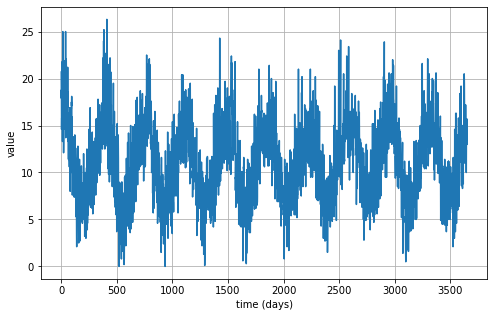

In [85]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(8,5))
plot_series(time, series)

In [ ]:
รูปที่ P5.1 ข้อมูลจุดบอดบนดวงอาทิตย์

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>